In [1]:
import scipy.signal as signal
import numpy as np 
import os, csv

In [2]:
import matplotlib.pylab as plt

In [3]:
% matplotlib inline

In [4]:
def load_data(subject_id, listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    day=1
    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)
                
    for file_name in data_file_names: 
        if subject_id in file_name: 
            subject_path = data_path + file_name
            if listen: print("loading data from subject'%s'"%file_name) 

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_data): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: np.arrays for pupil, CS+, CS-, US, and movie_frame information 
    
    """

    _pupil_ = [] 
    onsets  = []
    cs_type = []
    xy = []
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US

    # movie frame data prep 
    m_frame, i_frame = [], np.nan

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]  

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            _pupil_.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)
            m_frame.append(i_frame)
            
            # extract xy coordinates 
            if ' .' in msg[1] or ' .' in  msg[2]:
                xy.append([np.nan, np.nan])
            else: 
                xy.append([float(msg[1]), float(msg[2])])
            
        except: 

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: 
                    us_o = 1
                    cs_type[-1] =  cs_type[-1] + 'US'
                    
                    
                if 'OFF' in msg[1]: 
                    cs_p = 0
                    cs_n = 0
                    us_o = 0 

                if msg[0] == "MSG": 

                    if "VFRAME" in msg[1]: 

                        ind = str.find(msg[1], "VFRAME")
                        space = str.find(msg[1], " 0 0 /")
                        i_frame = int(msg[1][ind+7:space])
                    
                    if "TRIAL_ONSET" in msg[1]:
                        onsets.append(len(_pupil_))
                        cs_type.append(msg[1][-3:])
                    
                        
    
    data = {"pupil":np.array(_pupil_), 
            "CS+":np.array(cs_pos), 
            "CS-":np.array(cs_neg), 
            "US":np.array(us_sti), 
            "movie_frame":np.array(m_frame),
            "xy":np.array(xy), 
            "onsets":np.array(onsets),
            "cs_type":cs_type}
                    

    return data



In [217]:
subjects = ['12', '08']; i_subject = 1 
subject_data = load_data(subjects[i_subject], listen=1)

loading data from subject's08_d1.asc'


In [218]:
data = extract_data(subject_data) ; print('experimental information in data: ', list(data.keys())) 

experimental information in data:  ['pupil', 'CS+', 'CS-', 'US', 'movie_frame', 'xy', 'onsets', 'cs_type']


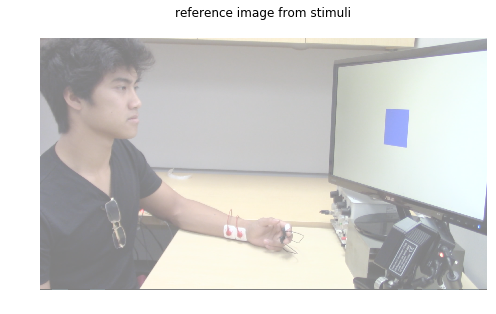

In [222]:
model_image = plt.imread('model_image.png')
y_len, x_len, _ = np.shape(model_image)
plt.figure(figsize=[8,5]) ; plt.axis('off')
plt.title('reference image from stimuli\n')
plt.imshow(model_image, alpha=.5); 

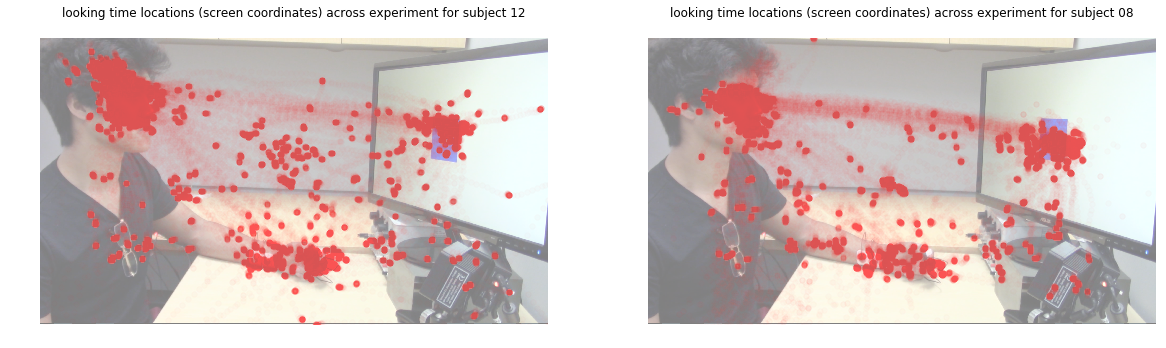

In [224]:
big_picture = 0

plt.figure(figsize=[20,8])
for i_subject in range(len(subjects)):  

    plt.subplot(1,2,i_subject+1); plt.axis('off')
    plt.imshow(model_image, alpha=.5)
    
    subject_data = load_data(subjects[i_subject])
    data = extract_data(subject_data)
        
    # need to do some rescaling to format gaze data with arbitrary-size jpeg
    plt.scatter(data['xy'][:,0]*1.9-200, data['xy'][:,1]*1.9-50,marker='o', s=30, alpha=.01, c = 'red')
    plt.title('looking time locations (screen coordinates) across experiment for subject %s\n'%subjects[i_subject]); 

    if not big_picture: plt.xlim([0, x_len]), plt.ylim([y_len, 0])

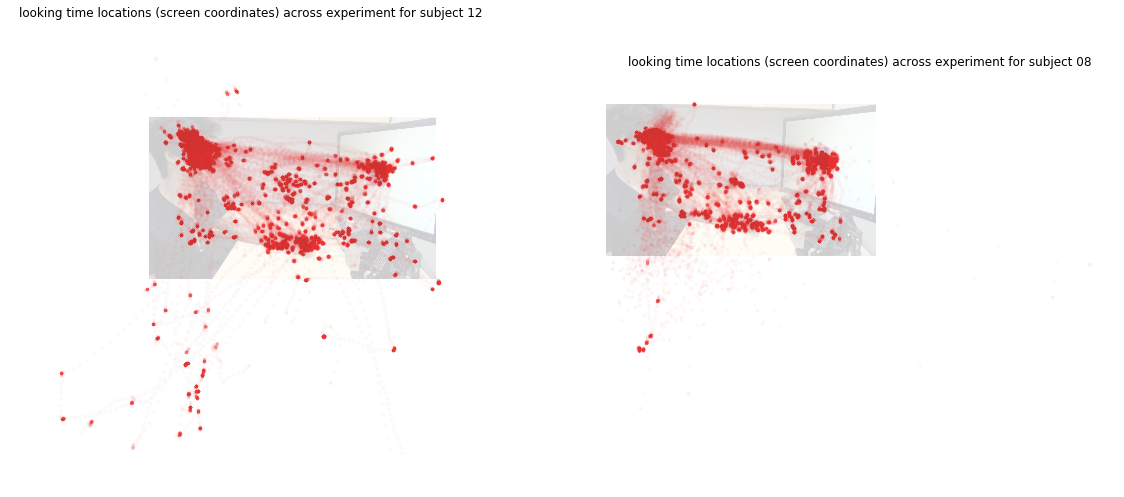

In [225]:
big_picture = 1

plt.figure(figsize=[20,8])
for i_subject in range(len(subjects)):  

    plt.subplot(1,2,i_subject+1); plt.axis('off')
    plt.imshow(model_image, alpha=.2)
    
    
    subject_data = load_data(subjects[i_subject])
    data = extract_data(subject_data)
        
    plt.scatter(data['xy'][:,0]*1.9-200, data['xy'][:,1]*1.9-50,marker='.', s=30, alpha=.02, c = 'xkcd:red')
    plt.title('looking time locations (screen coordinates) across experiment for subject %s\n'%subjects[i_subject]); 

    if not big_picture: plt.xlim([0, x_len]), plt.ylim([y_len, 0])

```
                          is that lower left shift towards their own hand? 
```

In [227]:
subject_data = load_data('12')
data = extract_data(subject_data)

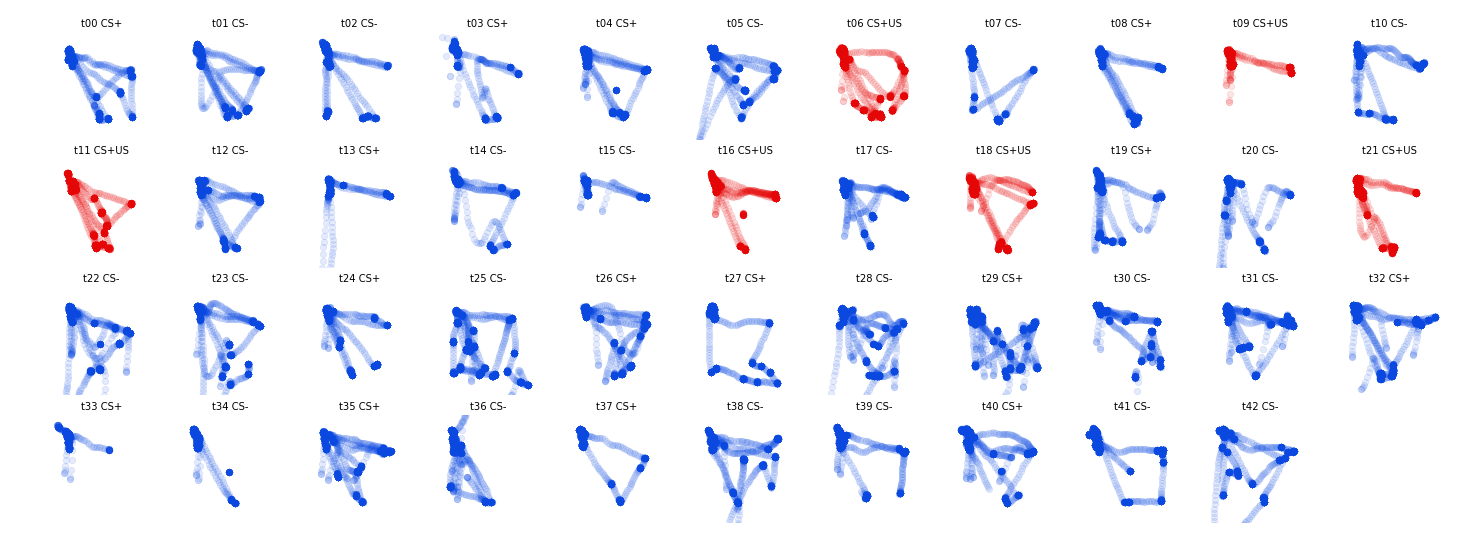

In [228]:
# interval info
xy = data['xy']
#show = np.insert(data['onsets'],0, 0)
show = data['onsets']

def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

# aesthetics
plt.figure(figsize=[25,9]); 
for ii in range(len(show)-1): 
    
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 2000]) ; 
    plt.ylim([-1000, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['cs_type'][ii])); 
    plt.title('\nt%02d %s'%(ii, data['cs_type'][ii]), fontsize=10)

```
                                is there more entropy after conditioning is over?
```


					gaze behavior across the experiment


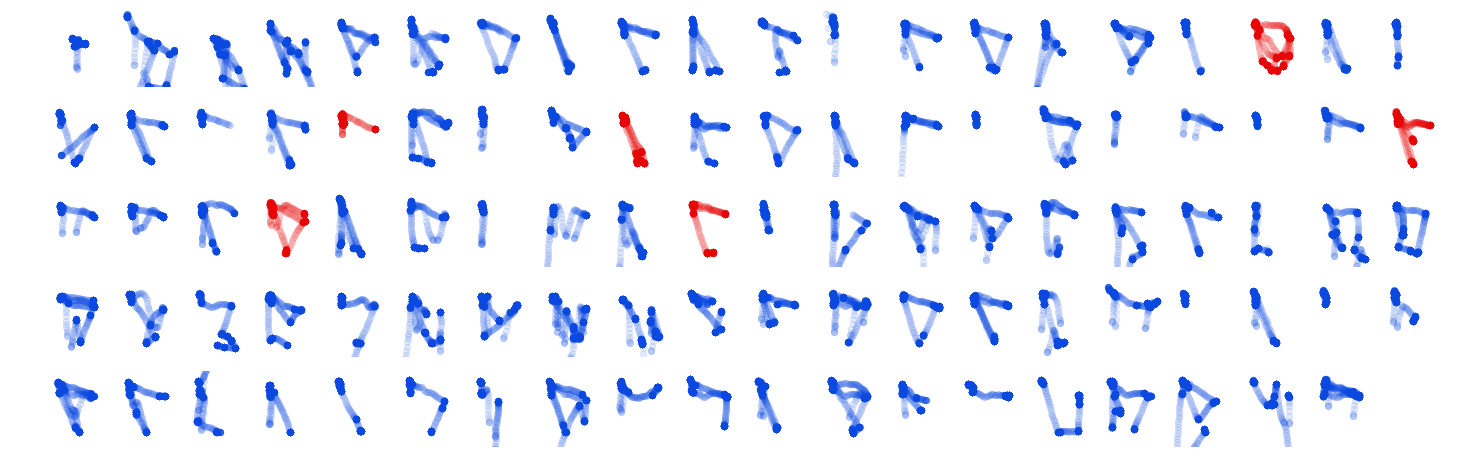

In [229]:
start, end = 0, len(data['xy']) 
step = round((end-start)/100)
show = np.arange(start, end, step)

# define US onsets in experiment
us_onsets = np.nonzero(np.convolve(data['US'], [1,-1]))[0]

def find_color(interval_0, interval_1, us_onsets, color = 'xkcd:blue'):    
    for i_onset in us_onsets: 
        if interval_0 < i_onset < interval_1: color = 'xkcd:red' 
    return color

plt.figure(figsize=[25,8]); 
for ii in range(len(show)-1): 
    
    # aesthetics
    plt.subplot(5,20,ii+1)
    plt.axis('off')
    plt.xlim([0, 2000]) ; 
    plt.ylim([-1000, 0])
    
    # plot data with US dependent color
    color = find_color(show[ii], show[ii+1], us_onsets)
    plt.scatter(data['xy'][show[ii]:show[ii+1],0],-data['xy'][show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = '%s'%color);

print('\n\t\t\t\t\tgaze behavior across the experiment')

```
                                again, more entropy after conditioning is over?
```

In [209]:
subjects = ['12', '08', '01', '11']; i_subject = 1 
subject_data = load_data(subjects[i_subject], listen=1)

loading data from subject's08_d1.asc'


> a possible approach: 
> - kmeans clustering (k = 3) on each subjects whole timecourse
> - assuming clusters are in a "reasonable" location
>    - use the total `inertia_` for each subject as a measure of attention -- one covariate
>    - use trial-level `inertia_` as a measure of attention -- or entropy 

In [200]:
from sklearn.cluster import KMeans as kmeans

In [273]:
def kmeans_coordinates(xy, with_image=0): 
    
    if with_image: a = 1
    else: a = - 1
    
    # ignore nans, flip (?) y axis, fit model
    keep_inds = xy[:,0] == xy[:,0]
    xy = xy[keep_inds] 
    # correct for inversion depending on image type
    xy[:,1] = a*xy[:,1]
    k = kmeans(n_clusters=3, random_state=0).fit(xy)
    
    return k, xy

k = kmeans_coordinates(data['xy'])

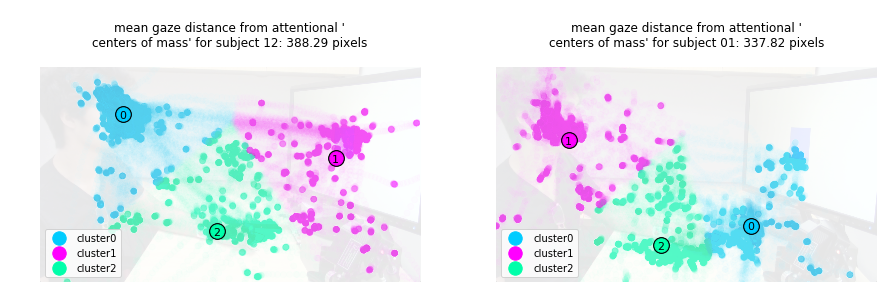

In [526]:
big_picture = 0

# subjects, colors, shape
subjects = ['12', '01'] #'08']# , '01', '09'];
colors = ['#00ccff', '#ff00ff', '#00ffaa'] #6600ff'] 
y_len, x_len, _ = np.shape(model_image)

# fits gaze data to arbitrary jpeg
scaling_factor = 1.8


plt.figure(figsize=[15, 12])
for i_subject in range(len(subjects)):
    
    # get subject's data
    subject_data = load_data(subjects[i_subject])
    data = extract_data(subject_data)

    # generate clusters and find data to color mapping
    k, xy = kmeans_coordinates(data['xy']*scaling_factor, with_image=1)
    point_colors = [colors[ii] for ii in k.labels_]
    
    # setup plot
    plt.subplot(2,2,i_subject+1); plt.axis('off')
    # show background experimental stimuli
    plt.imshow(model_image, alpha=.1)
    # plot gaze data according to cluster color
    plt.scatter(xy[:,0],xy[:,1],  alpha=.01, c = point_colors)
    # extract centers of mass for each cluster
    centers = np.round(k.cluster_centers_)
    
    # plot center of mass for each cluster in a way we can clearly lable in legend
    for i_loc in range(len(centers)):
        
        plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
        
        plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                    s=180, c=colors[i_loc], label='cluster%s'%i_loc)
        
        plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                     xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)
    
    # control aesthetics
    if not big_picture: plt.xlim([0, x_len]), plt.ylim([y_len, 0])
    plt.legend(['cluster1', 'cluster2', 'cluster3']); ax = plt.gca(); ax.legend(loc=3)
    plt.title("\nmean gaze distance from attentional '\ncenters of mass' for subject %s: %.02f pixels\n" 
              %(subjects[i_subject], np.sqrt(k.inertia_/len(xy)) ) )

> that is, '12' is looking more broadly across the screen while '08' is attending more focally to the centers of mass. 

> now we need to generate subests of the data, across the experiment, and calculate the average distance between each of these subsamples and the centers of mass

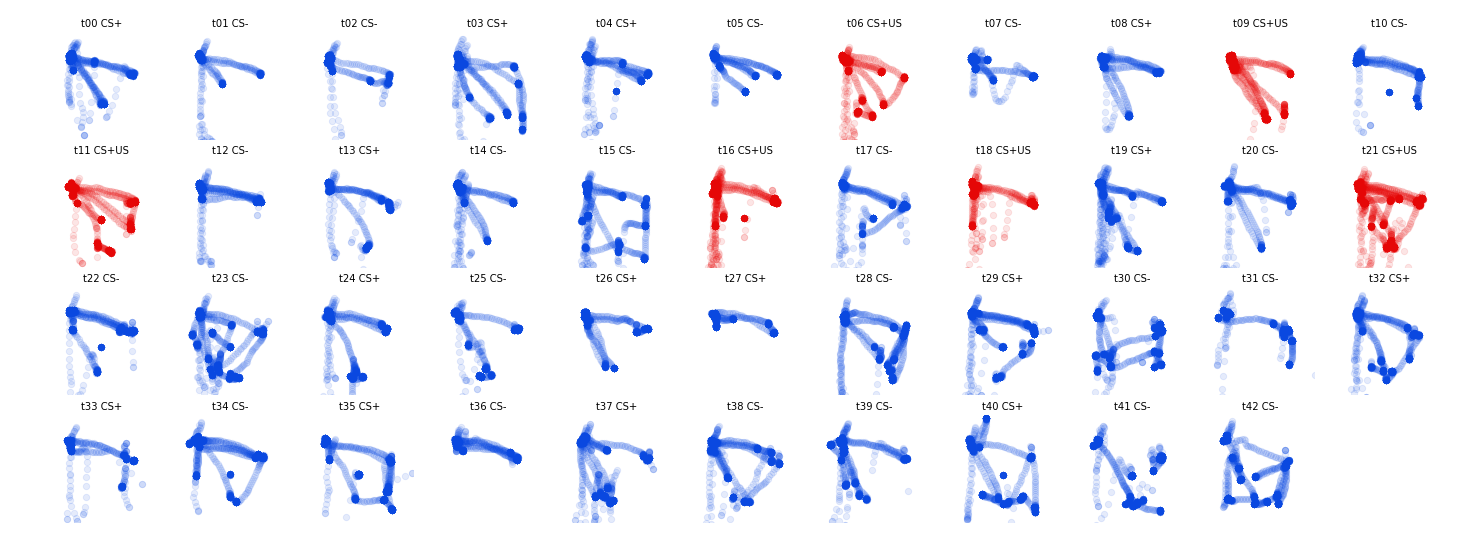

In [412]:
# interval info
xy = data['xy']
#show = np.insert(data['onsets'],0, 0)
show = data['onsets']

def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

# aesthetics
plt.figure(figsize=[25,9]); 
for ii in range(len(show)-1): 
    
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 2000]) ; 
    plt.ylim([-1000, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['cs_type'][ii])); 
    plt.title('\nt%02d %s'%(ii, data['cs_type'][ii]), fontsize=10)

In [499]:
keep_inds = xy[:,0] == xy[:,0]

217134

In [502]:
ii = 30

gaze_within = XY[show[ii]:show[ii+1]] 
lab_within = k.labels_[show[ii]:show[ii+1]] 

gaze_clustered = gaze_within[lab_within==i_lable]
cluster_difference = gaze_clustered - k.cluster_centers_[0]

In [534]:
len( data['xy']), len(XY)

(229765, 217134)

In [543]:
# get subject's data
subject_data = load_data(subjects[i_subject])
data = extract_data(subject_data)

# generate clusters and find data to color mapping
k, xy = kmeans_coordinates(data['xy'], with_image=1)

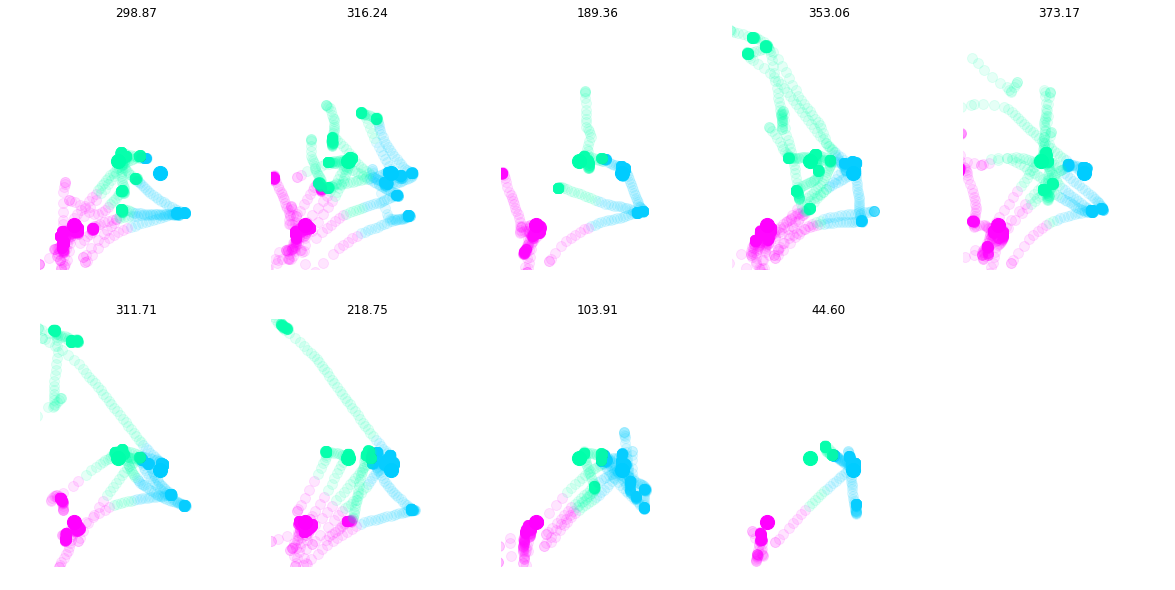

In [633]:
show = data['onsets']

colors = ['#00ccff', '#ff00ff', '#00ffaa'] 
intervals = np.arange(0, 10)

plt.figure(figsize=[20,10])

for i_interval in range(len(intervals)-1): 

    gaze_within = xy[show[i_interval]:show[i_interval+1]] 
    lab_within = k.labels_[show[i_interval]:show[i_interval+1]]
        
    ss_cluster_difference = np.zeros(3)
    for i_lable in [0,1,2]: 
        
        gaze_clustered = gaze_within[lab_within==i_lable]
        ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[0])**2))

        plt.subplot(2,5,i_interval+1); plt.axis('off')
        plt.scatter(gaze_clustered[:,0], gaze_clustered[:,1], c=colors[i_lable], 
                    s=100, alpha=.1, label='%s in cluster %s'%(len(gaze_clustered), i_lable))
        plt.scatter(k.cluster_centers_[i_lable][0], k.cluster_centers_[i_lable][1],
                    c=colors[i_lable], s=200, label='%s in cluster %s'%(len(gaze_clustered), i_lable)) 
    
    plt.xlim([0, 2000])
    plt.ylim([0, 2000])    

    plt.title('%.02f'%(sum(ss_cluster_difference)/10e6))

In [ ]:
def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

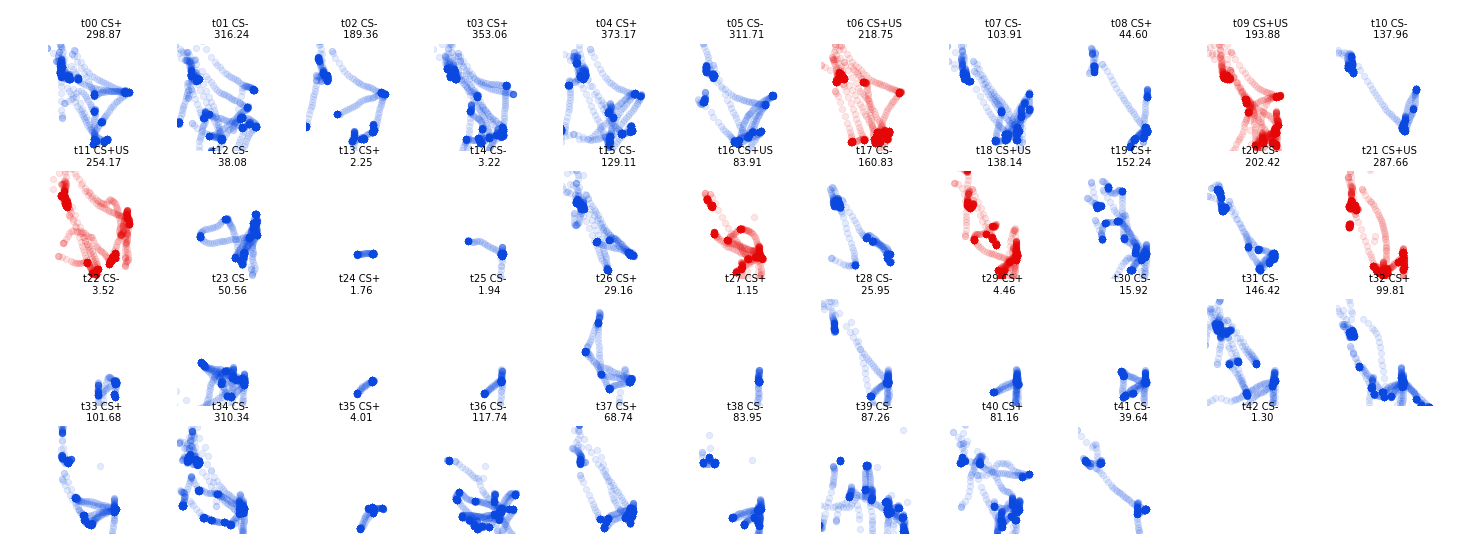

In [665]:
# get subject's data
subject_data = load_data(subjects[i_subject])
data = extract_data(subject_data)

# generate clusters and find data to color mapping
k, xy = kmeans_coordinates(data['xy'], with_image=1)
show = data['onsets']

# aesthetics
plt.figure(figsize=[25,9]); 
for ii in range(len(show)-1): 
        
    gaze_within = xy[show[ii]:show[ii+1]] 
    lab_within = k.labels_[show[ii]:show[ii+1]]
    ss_cluster_difference = np.zeros(3)
    
    for i_lable in [0,1,2]:         
        gaze_clustered = gaze_within[lab_within==i_lable]
        if not len(gaze_clustered): gaze_clustered = np.zeros([2,2])
        ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[0])**2))

    
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 2000]) ; 
    plt.ylim([-1000, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['cs_type'][ii])); 
    
    plt.title('\nt%02d %s\n %.02f' 
              %(ii, data['cs_type'][ii], (np.sum(ss_cluster_difference)/10e6) ), fontsize=10)
    

In [20]:
subject_data[10000:10020]

[['36864191', '  445.9', '  203.0', ' 6059.0', '...'],
 ['36864193', '  445.9', '  202.7', ' 6058.0', '...'],
 ['36864195', '  445.8', '  203.1', ' 6056.0', '...'],
 ['36864197', '  446.1', '  203.6', ' 6055.0', '...'],
 ['36864199', '  446.5', '  203.9', ' 6057.0', '...'],
 ['36864201', '  446.7', '  203.8', ' 6059.0', '...'],
 ['36864203', '  446.4', '  203.6', ' 6061.0', '...'],
 ['36864205', '  446.0', '  203.3', ' 6061.0', '...'],
 ['36864207', '  445.7', '  203.3', ' 6060.0', '...'],
 ['36864209', '  445.7', '  203.1', ' 6059.0', '...'],
 ['36864211', '  445.7', '  203.0', ' 6059.0', '...'],
 ['36864213', '  445.6', '  203.0', ' 6060.0', '...'],
 ['36864215', '  445.3', '  203.2', ' 6063.0', '...'],
 ['36864217', '  444.9', '  203.6', ' 6067.0', '...'],
 ['MSG',
  '36864219 -15068 !V VFRAME 132 0 0 /Users/ssnl_booth2/Desktop/model_experiment_two.MP4'],
 ['36864219', '  444.5', '  203.6', ' 6069.0', '...'],
 ['36864221', '  444.6', '  203.5', ' 6071.0', '...'],
 ['36864223', '  44